In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from DeepTaxonNet import DeepTaxonNet
import argparse
import utils

from sklearn.mixture import GaussianMixture

import os
import sys

In [3]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('omniglot', 128, False)

Initializing EpisodeDataset: Indexing dataset by class...
--> Manually indexing dataset by class (can be slow for large datasets)...
    (Dataset lacks `get_label` method, will load items via __getitem__ for indexing)
--> Manual indexing complete. Found 659 valid classes.
-> Indexing complete in 9.84 seconds.
-> Found 659 classes with enough samples.
EpisodeDataset ready: Using 659 classes for 5-way 1-shot tasks (15 query samples/class).
Generating 600 episodes per epoch.


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
train_set[0][0].shape

torch.Size([3, 32, 32])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [5]:
def t_sne(model, test_loader, device, epoch):
    all_latent = []
    all_labels = []
    all_pcx = []
    pis = []
    mu_c = None
    for i, (data, target) in enumerate(test_loader):
        with torch.no_grad():
            data = data.to(device)
            mu, logvar = model.encode(data)
            latent = model.reparameterize(mu, logvar)
            all_latent.append(latent)
            all_labels.append(target)

            _, recon_loss, kl1, kl2, H, pcx, pi, sym_kl = model(data)
            all_pcx.append(pcx)
            # pis.append(pi)
            pis = pi.cpu().numpy()


            if i == 10:
                break
            mu_c = model.gmm_params()[1]
    #         centroids = model.decode(mu_c)
    #         centroids = centroids.view(-1, 3, 32, 32).detach().cpu().numpy()
    #         # plot 8 * 8 centroids 
    # plt.figure(figsize=(8, 8))
    # for i in range(len(centroids)):
    #     plt.subplot(16, 16, i+1)
    #     plt.imshow(centroids[i], cmap='gray')
    #     plt.axis('off')
    # plt.savefig('viz_out/vade_muc.png')
    # plt.close()
    # plt.show()

    # plot entropy at each layer
    num_layers = len(H)
    colors = plt.cm.viridis(np.linspace(0, 1, num_layers))
    fig = plt.figure(figsize=(5, 5))
    for i, entropy in enumerate(H):
        entropy = entropy.cpu().numpy()
        plt.scatter(np.arange(entropy.shape[0]), entropy, alpha=0.5, color=colors[i], label=f'layer {i}')
    plt.savefig(f'viz_out/vade_entropy.png')
    plt.legend()
    plt.close()

    num_layers = len(sym_kl)
    colors = plt.cm.viridis(np.linspace(0, 1, num_layers))
    fig = plt.figure(figsize=(5, 5))
    for i, dkl in enumerate(sym_kl):
        dkl = dkl.cpu().numpy()
        plt.scatter(np.arange(dkl.shape[0]), dkl, alpha=0.5, color=colors[i], label=f'layer {i}')
    plt.legend()
    plt.savefig(f'viz_out/vade_sym_kl.png')
    plt.close()




    all_latent = torch.cat(all_latent, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_latent = all_latent.cpu().numpy()
    # concate with mu_c
    all_latent = np.concatenate((all_latent, mu_c.detach().cpu().numpy()), axis=0)
    all_labels = all_labels.cpu().numpy()

    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(all_latent)
    # plt.figure(figsize=(5, 5))
    # subplots, 1 by 3
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].scatter(tsne_results[:len(all_labels), 0], tsne_results[:len(all_labels), 1], c=all_labels, s=5)
    # axs[0].colorbar()
    axs[0].scatter(tsne_results[len(all_labels):, 0], tsne_results[len(all_labels):, 1], c='black', s=20, marker='x')
    # plt.colorbar()


    # subplot 2, pcx 
    pcx = torch.cat(all_pcx, dim=0) # batch_size, n_classes
    pcx = pcx.cpu().numpy()
    # plot line plot for each data point and color by label
    axs[1].plot(pcx[:len(all_labels), :].T, c='blue', alpha=0.003)
    # multiple bars
    # for i in range(pcx.shape[0]):
        # axs[1].bar(np.arange(pcx.shape[1]), pcx[i], color='blue', alpha=0.005)

    # subplot 3, pi, shape (n_classes,)
    axs[2].plot(pis.T, c='red', alpha=0.5)
    # axs[2].bar(np.arange(pis.shape[0]), pis, color='red', alpha=0.5)

    # plt.savefig(f'viz_out/vade{epoch}.png')
    # plt.savefig(f'viz_out/vade_tree_{epoch}.png')
    plt.savefig(f'viz_out/vade_tree_0.png')

    plt.close()






In [11]:
n_layers=12
# model = DeepTaxonNet(
#     n_layers=n_layers,
#     enc_hidden_dim=32*3*3,
#     dec_hidden_dim=(32,3,3),
#     input_dim=1*28*28,
#     latent_dim=10,
#     encoder_name='mnist',
#     decoder_name='mnist',
#     kl1_weight=1
# ).to(device)

# model = DeepTaxonNet(
#     n_layers=n_layers,
#     enc_hidden_dim=64*8*8,
#     dec_hidden_dim=(64,8,8),
#     input_dim=3*32*32,
#     latent_dim=64,
#     encoder_name='resnet18_light',
#     decoder_name='resnet18_light',
#     kl1_weight=1,
#     dkl_margin=1.2,
#     # dkl_weight_lambda=0.0,
#     # convex_weight_lambda=0.05,
# ).to(device)

model = DeepTaxonNet(
    n_layers=n_layers,
    enc_hidden_dim=128*1*1,
    dec_hidden_dim=(128,1,1),
    input_dim=1*28*28,
    latent_dim=8,
    encoder_name='omniglot',
    decoder_name='omniglot',
    kl1_weight=1,
    dkl_margin=0,
    # dkl_weight_lambda=0.0,
    # convex_weight_lambda=0.05,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
# add a scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.09)
noise_scheduler = utils.NoiseScheduler(1000, 1.0, 0.001)
# pretrain
optimizer_pretrain = optim.AdamW(
    list(model.encoder.parameters()) + 
    list(model.decoder.parameters()) +
    list(model.fc_mu.parameters()),
    # list(model.fc_logvar.parameters()),
    lr=1e-3,
)
utils.pretrain(model, train_loader, optimizer_pretrain, 0, device) 

# train 
epochs = 100
for epoch in range(epochs):
    model.train()
    for i, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # print('data shape:', data.shape)
        #---------ELBO loss------------#
        optimizer.zero_grad()
        # model.noise_strength = noise_scheduler.get_noise()
        if epoch < 10:
            model.noise_strength = 0.0
        elif epoch < 30:
            
            model.noise_strength = 0.1
        elif epoch < 50:
            model.noise_strength = 0.2

        # recon_weight, kl1_weight = utils.get_loss_weights(i, 0, 1, 'dkl')
        # model.kl1_weight = kl1_weight
        # model.recon_weight = recon_weight

        loss, recon_loss, kl1, kl2, _, _, _, _ = model(data)
        # loss, recloss, kl1, _ = model.vae_forward(data)
        # print('loss:', loss.item(), 'recloss:', recloss.item(), 'kl1:', kl1.item(), 'kl2:', kl2.item())
        # break
        # print('kl1:', kl1.item(), 'recloss:', recon_loss.item())
        #----------------------------#
        loss.backward()
        optimizer.step()
        # noise_scheduler.step()
        # if i % 100 == 0:
    print('Epoch:', epoch, 'Loss:', loss.item())
    scheduler.step()

    # testing
    # utils.linear_probing(model, 10, mnist_train_loader, mnist_test_loader, 1e-3, 1, device)
    # if epoch==9:
        # all_latent, all_labels, pcx, pis, centroid_list, H = utils.get_latent(model, test_loader, device)
    
    if epoch % 2 == 1:
        model.eval()
        t_sne(model, train_loader, device, epoch)

0it [00:00, ?it/s]
/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


tensor([[6.8810e-01],
        [1.1728e-01],
        [3.3683e-01],
        ...,
        [1.5622e-04],
        [1.9166e-04],
        [2.4167e-04]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[6.8810e-01],
        [1.1865e-01],
        [3.3692e-01],
        ...,
        [1.5661e-04],
        [1.9199e-04],
        [2.4143e-04]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[6.8810e-01],
        [1.2135e-01],
        [3.3699e-01],
        ...,
        [1.5688e-04],
        [1.9231e-04],
        [2.4140e-04]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[6.8784e-01],
        [1.2338e-01],
        [3.3698e-01],
        ...,
        [1.5685e-04],
        [1.9228e-04],
        [2.4164e-04]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[6.8811e-01],
        [1.2560e-01],
        [3.3863e-01],
        ...,
        [1.5694e-04],
        [1.9228e-04],
        [2.4113e-04]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[6.9045e-01],
        [1.2712e-01],
        [3.4234e-01],

KeyboardInterrupt: 

In [54]:
# load model
n_layers=5

model = DeepTaxonNet(
    n_layers=n_layers,
    enc_hidden_dim=32*3*3,
    dec_hidden_dim=(32,3,3),
    input_dim=1*28*28,
    latent_dim=10,
    encoder_name='mnist',
    decoder_name='mnist',
    kl1_weight=1
).to(device)
model.load_state_dict(torch.load('vade_fashion_mnist_tree.pth'))

<All keys matched successfully>

In [12]:
F.sigmoid(model.layers[-1].cluster_weight)

tensor([[0.5025]], device='cuda:0', grad_fn=<SigmoidBackward0>)

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


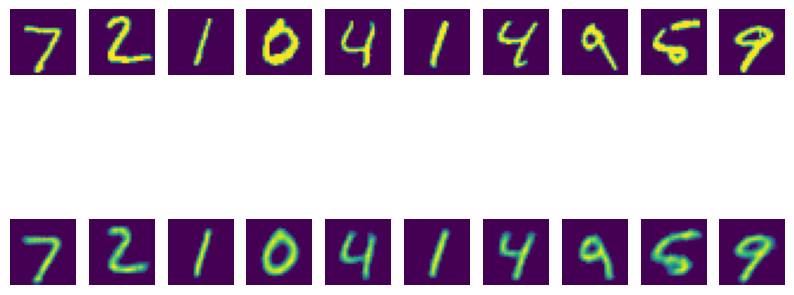

In [11]:
# test image reconstruction
model.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        latent, logvar = model.encode(data)
        latent = model.reparameterize(latent, logvar)
        x_hat = model.decode(latent)
        # latent = model.encoder(data)
        # x_hat = model.decoder_raw(latent)
        break

# plot original and reconstructed images
# original images
data = data.view(-1, 1, 28, 28).cpu().numpy()[:10]
# reconstructed images
x_hat = x_hat.view(-1, 1, 28, 28).cpu().numpy()[:10]
# plot 10 images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(data[i].transpose(1, 2, 0))
    plt.axis('off')
    plt.subplot(2, 10, i+11)
    plt.imshow(x_hat[i].transpose(1, 2, 0))
    plt.axis('off')

plt.show()

In [13]:
all_latent, all_labels, pcx, pis, centroid_list, H = utils.get_latent(model, test_loader, device)


In [62]:
annotation = utils.label_annotation(model, train_set, 10, device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [59]:
acc = utils.basic_node_evaluation(model, annotation, test_set, device)
print('Accuracy:', acc)

Accuracy: 0.9032


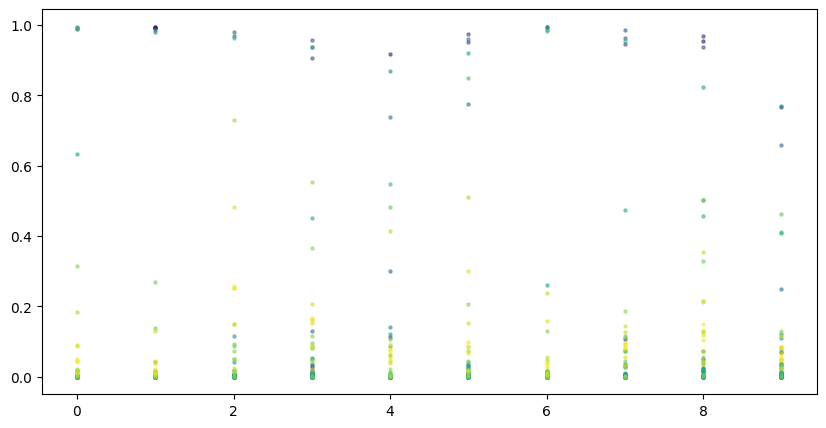

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

cmap = plt.get_cmap('viridis', annotation.shape[1])

for node in range(annotation.shape[1]):
    dist = annotation[:, node]
    x = np.arange(dist.shape[0])
    ax.scatter(x, dist, label=node, alpha=0.5, color=cmap(node), s=5)
    # ax.plot(x, dist, label=node, alpha=0.5, color=cmap(node))
    # bar
    # ax.bar(x, dist, label=node, alpha=0.5, color=cmap(node), width=0.1)
# plt.legend()
plt.show()

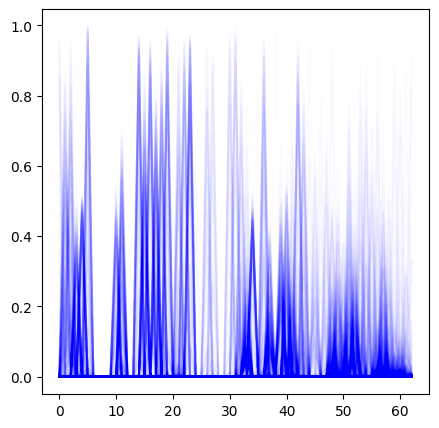

In [17]:
utils.plot_qcx(pcx).show()

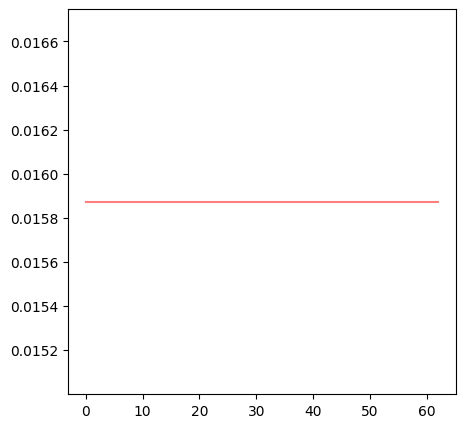

In [49]:
utils.plot_pi(pis).show()

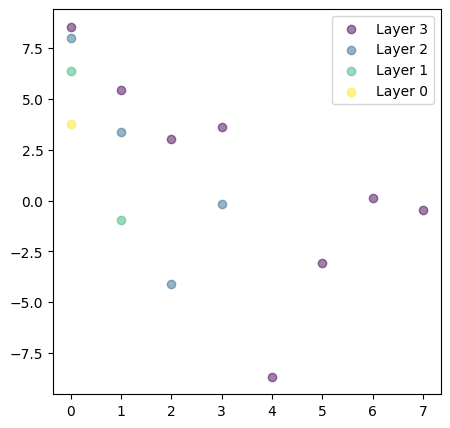

In [121]:
utils.plot_entropy(H).show()

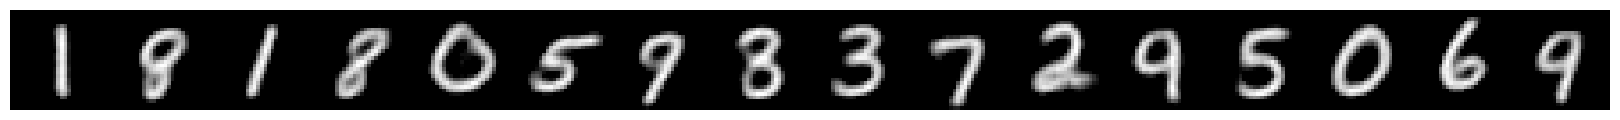

In [20]:
utils.plot_centroids(centroid_list, 4).show()

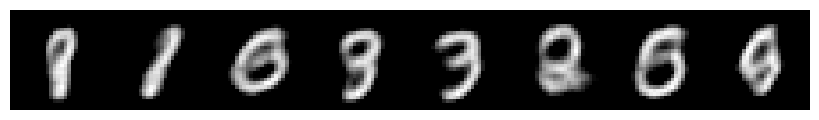

In [15]:
utils.plot_centroids(centroid_list, 3).show()

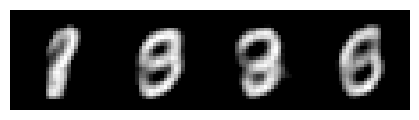

In [16]:
utils.plot_centroids(centroid_list, 2).show()

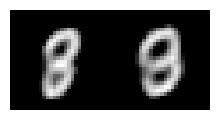

In [17]:
utils.plot_centroids(centroid_list, 1).show()

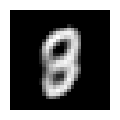

In [18]:
utils.plot_centroids(centroid_list, 0).show()

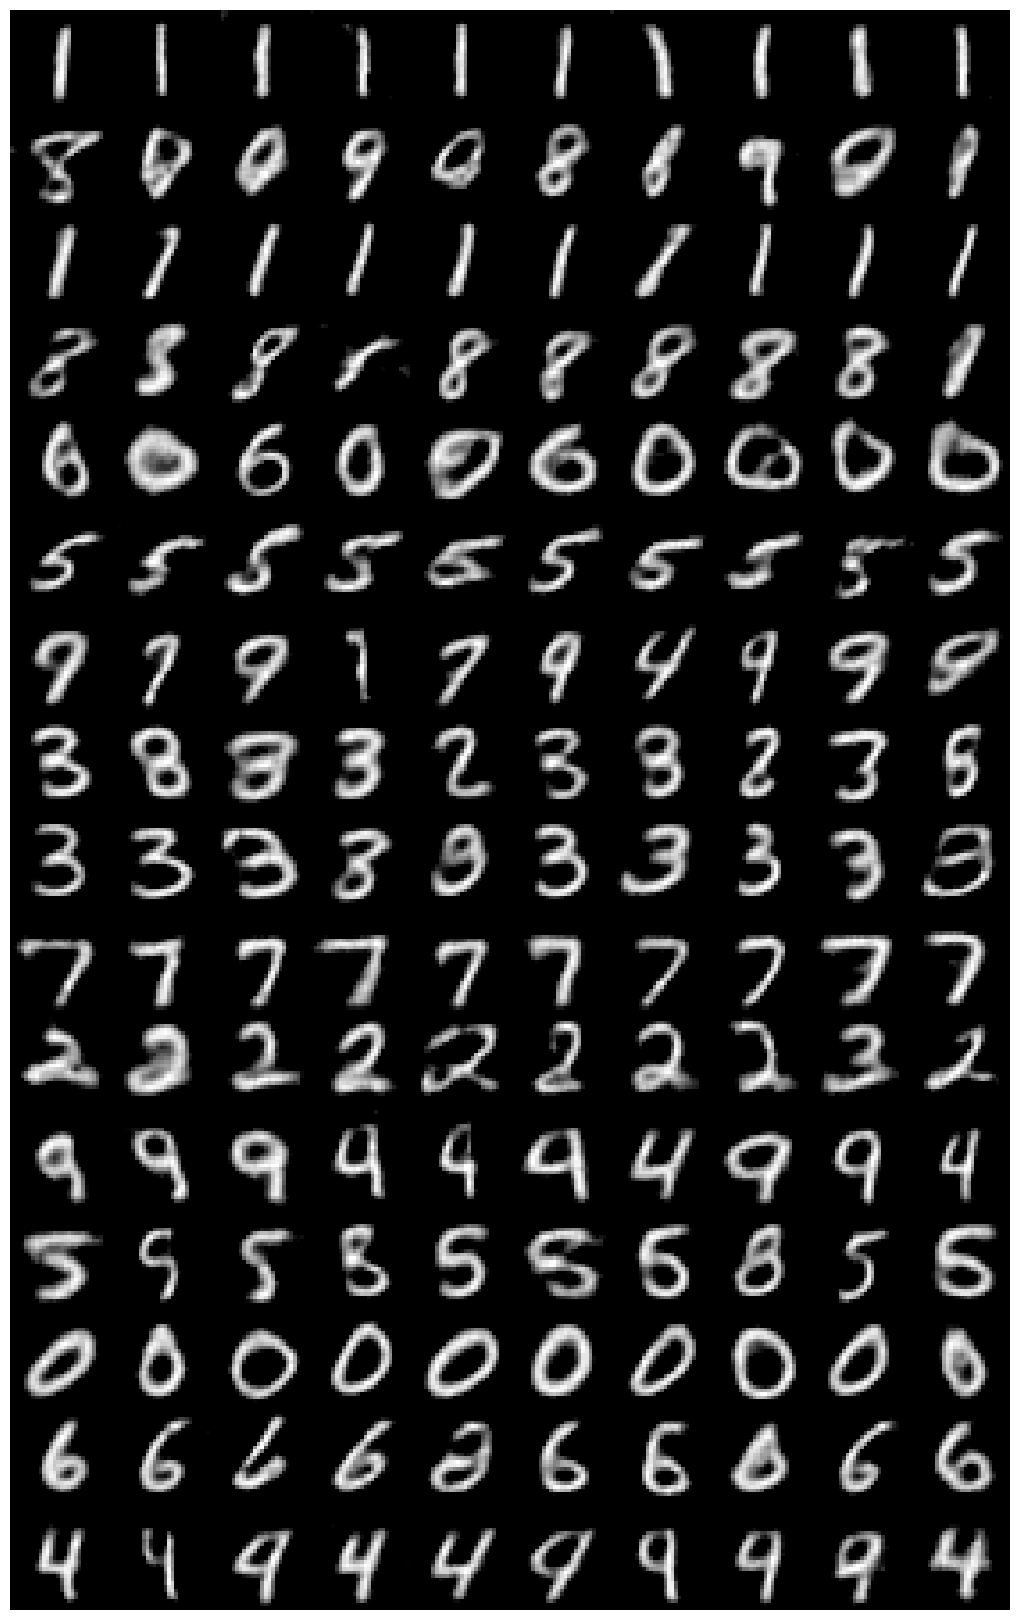

In [23]:
utils.plot_generated_examples(model, 4, 10, device).show()

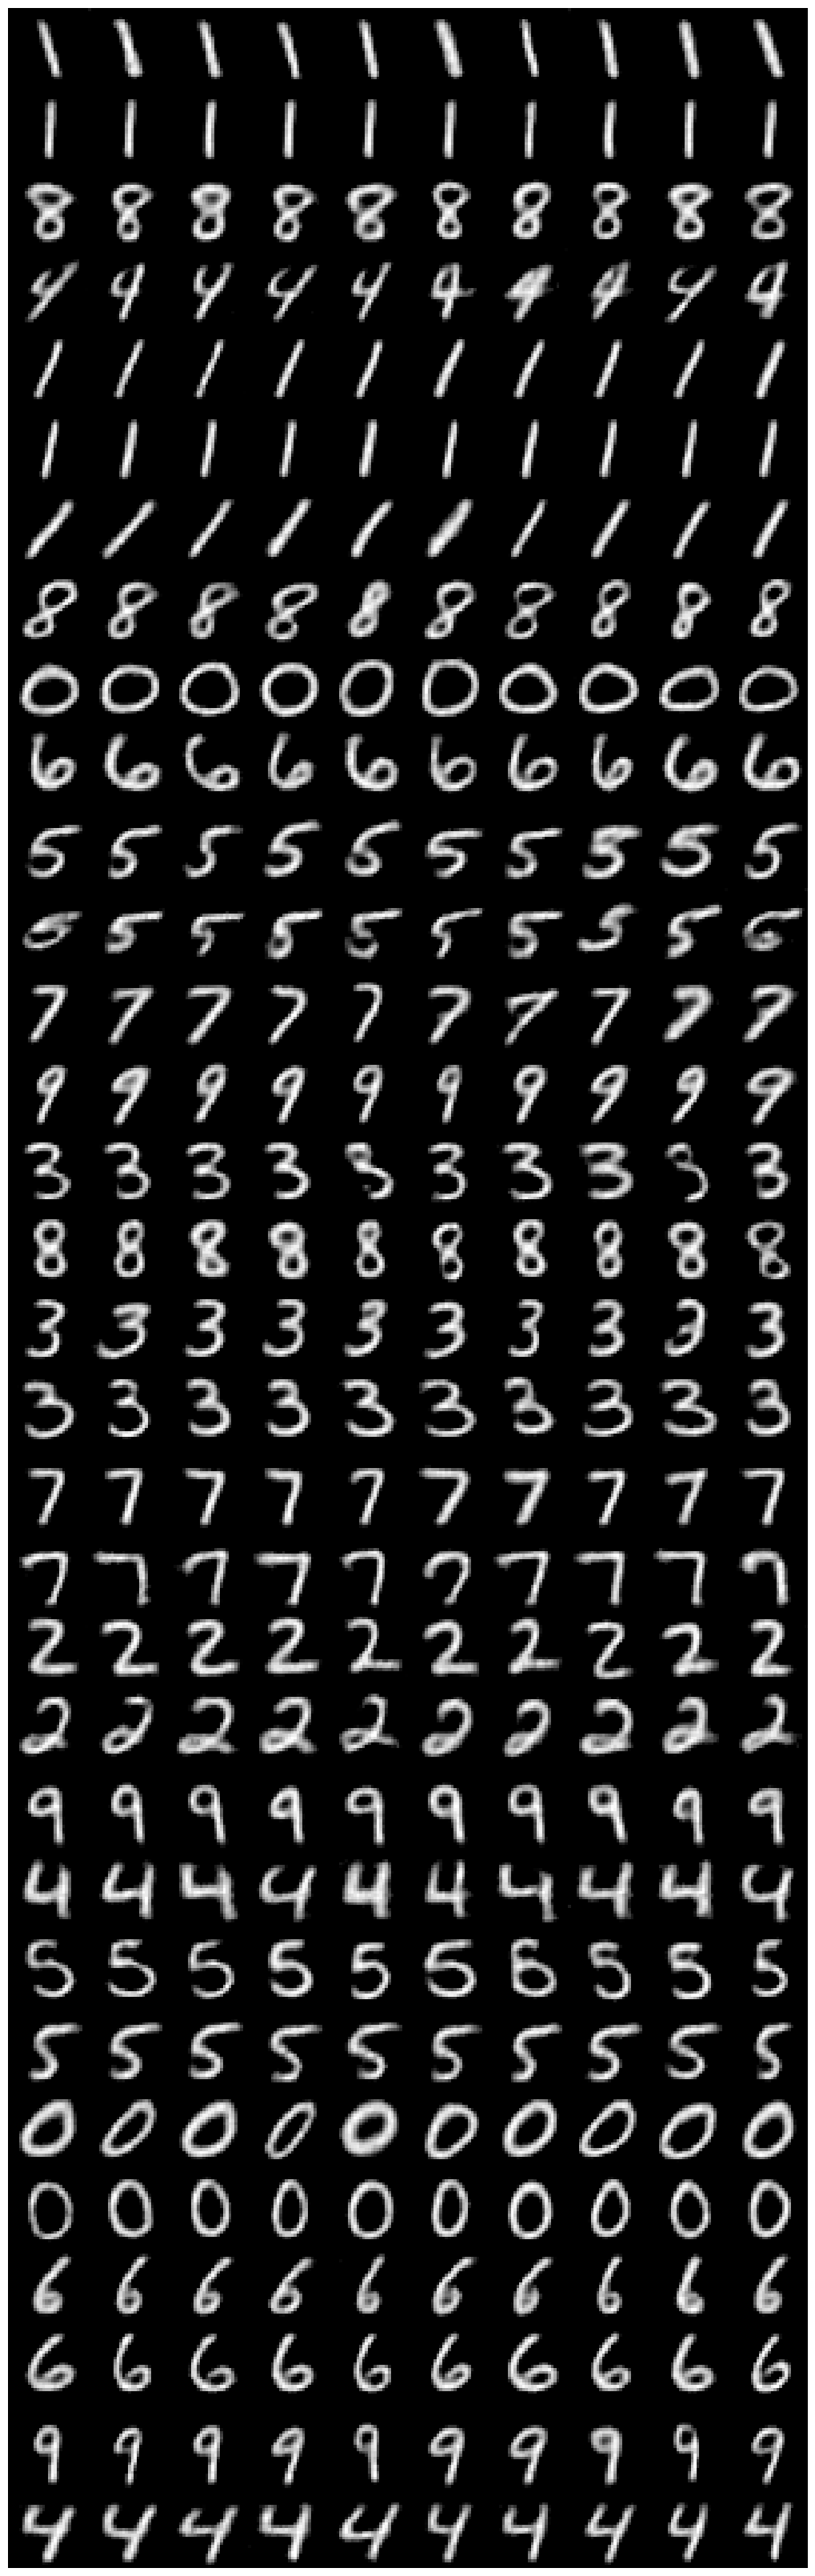

In [25]:
utils.plot_dataset_examples(model, all_latent, pcx, 5, 10, device).show()

In [46]:
# save model
torch.save(model.state_dict(), 'vade_fashion_mnist_tree.pth')

In [33]:
# load model
n_layers=4
model = GMMDeepTaxonNet(n_layers=n_layers, 
                        encoder_shared=True
                        ).to(device)
model.load_state_dict(torch.load('vade_tree.pth'))

<All keys matched successfully>

In [47]:
# linear probing
model.eval()
# freeze model
for param in model.parameters():
    param.requires_grad = False
# add linear layer
classifier = nn.Linear(model.latent_dim, 10).to(device)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=1e-2)
classifier_loss = nn.CrossEntropyLoss()
# train linear layer
epochs = 100

for epoch in range(epochs):
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        #---------ELBO loss------------#
        optimizer.zero_grad()
        with torch.no_grad():
            mu, logvar = model.encode(data)
            latent = model.reparameterize(mu, logvar)
        # print('latent:', latent.shape)
        output = classifier(latent)
        loss = classifier_loss(output, target)
        # print('loss:', loss.item(), 'recloss:', recloss.item(), 'kl1:', kl1.item(), 'kl2:', kl2.item())
        # break
        # print('kl1:', kl1.item(), 'kl2:', kl2.item())
        #----------------------------#
        loss.backward()
        classifier_optimizer.step()
    print('Epoch:', epoch, 'Loss:', loss.item())
    # test linear layer
    model.eval()
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            mu, logvar = model.encode(data)
            latent = model.reparameterize(mu, logvar)
            output = classifier(latent)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print('Accuracy:', correct / total)




Epoch: 0 Loss: 0.8998202681541443
Accuracy: 0.667
Epoch: 1 Loss: 1.2872430086135864
Accuracy: 0.6926
Epoch: 2 Loss: 1.405171513557434
Accuracy: 0.6965
Epoch: 3 Loss: 1.5855112075805664
Accuracy: 0.6858
Epoch: 4 Loss: 1.2203313112258911
Accuracy: 0.7065
Epoch: 5 Loss: 1.446583867073059
Accuracy: 0.6839
Epoch: 6 Loss: 1.772274136543274
Accuracy: 0.6592
Epoch: 7 Loss: 1.6047440767288208
Accuracy: 0.6615
Epoch: 8 Loss: 2.2280385494232178
Accuracy: 0.6723
Epoch: 9 Loss: 2.1089210510253906
Accuracy: 0.6464


KeyboardInterrupt: 

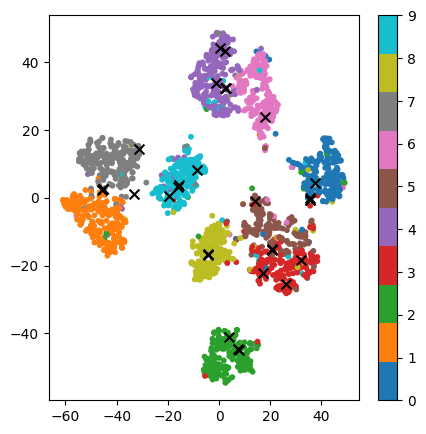

In [9]:
# plot datapoints along with the centroids
all_latent = []
all_labels = []
mu_c = None

with torch.no_grad():
    for i, (data, target) in enumerate(mnist_test_loader):
        data = data.view(-1, 28*28).to(device)
        mu, logvar = model.encode(data)
        latent = model.reparameterize(mu, logvar)
        all_latent.append(latent)
        all_labels.append(target)
        if i == 1:
            break
    mu_c = model.gmm_params()[1].detach().cpu().numpy()
    # mu_c = mu_c[-5:]
    # print(mu_c.shape)


all_latent = torch.cat(all_latent, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_latent = all_latent.cpu().numpy()
# concate with mu_c
all_latent = np.concatenate((all_latent, mu_c), axis=0)


all_labels = all_labels.cpu().numpy()

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(all_latent)
plt.figure(figsize=(5, 5))
plt.scatter(tsne_results[:len(all_labels), 0], tsne_results[:len(all_labels), 1], c=all_labels, cmap='tab10', s=10)
plt.colorbar()
plt.scatter(tsne_results[len(all_labels):, 0], tsne_results[len(all_labels):, 1], c='black', s=50, marker='x')


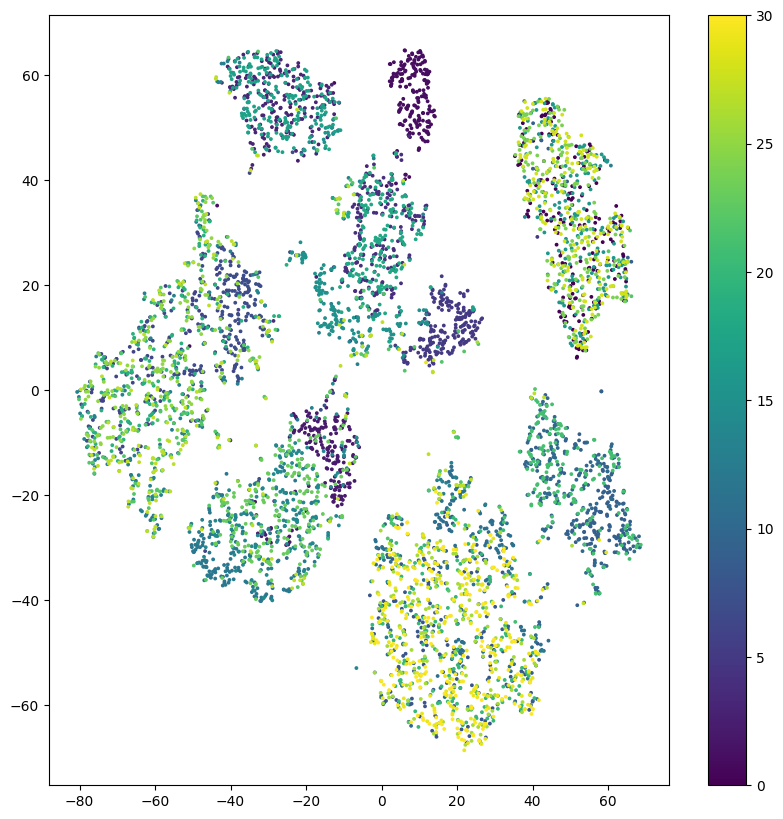

In [62]:
# plot gmms by samplign 100 datapoints at each cluster
# sample 100 points from each cluster
n_samples = 200
with torch.no_grad():
    mu_c = model.gmm_params()[1]
    lagvar_c = model.gmm_params()[2] # n_classes, latent_dim
    # for each cluster, sample 100 points

    labels = torch.arange(len(mu_c)).unsqueeze(1).expand(-1, n_samples).reshape(-1) # n_classes * n_samples
    # print(labels) 

    mu_c = mu_c.unsqueeze(1).repeat(1, n_samples, 1).reshape(-1, model.latent_dim)
    lagvar_c = lagvar_c.unsqueeze(1).repeat(1, n_samples, 1).reshape(-1, model.latent_dim) # n_classes * n_samples, latent_dim
    # print(lagvar_c)
    z = model.reparameterize(mu_c, lagvar_c)

    # tsne
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(z.cpu().numpy())
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne_results[:len(labels), 0], tsne_results[:len(labels), 1], c=labels, cmap='viridis', s=3, marker='o')
    plt.colorbar()
    # plt.savefig('viz_out/vade_gmm.png')
    plt.show()



    # x_hat = model.decode(z)




In [18]:
with torch.no_grad():
    for i, (data, target) in enumerate(mnist_test_loader):
        data = data.view(-1, 28*28).to(device)
        # forward pass
        model(data)
        if i == 0:
            break

torch.Size([30, 32]) torch.Size([30, 32]) torch.Size([30])


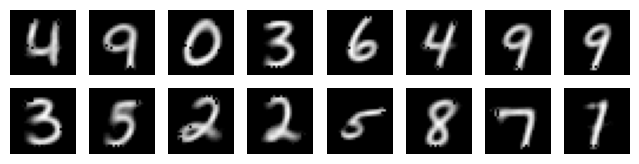

In [14]:
# decode the centroids
at_layer = 5 # root layer
if at_layer == 1:
    centroids = model.gmm_params()[1][-(2**(at_layer)-1):]
else:
    centroids = model.gmm_params()[1][-(2**(at_layer)-1):-(2**(at_layer-1)-1)]

# centroids = torch.zeros(1, 32).to(device)
centroids = model.decode(centroids)
centroids = centroids.view(-1, 28, 28).detach().cpu().numpy()
# plot 8 * 8 centroids 
plt.figure(figsize=(8, 8))
for i in range(len(centroids)):
    plt.subplot(8, 8, i+1)
    plt.imshow(centroids[i], cmap='gray')
    plt.axis('off')
# plt.savefig('viz_out/centroids.png')
plt.show()

In [15]:
# print gaussian p(c) at each layer
pi = model.gmm_params()[0].detach().cpu().numpy()
# print('pi:', pi)
# print pi
n_layers = model.n_layers
for i in range(0, n_layers):
    if i == 0:
        print('Layer:', i, 'p(c):', pi[-(2**(i+1)-1):])
    else:
        print('Layer:', i, 'p(c):', pi[-(2**(i+1)-1):-(2**i-1)])

Layer: 0 p(c): [0.04656837]
Layer: 1 p(c): [0.06666263 0.0200983 ]
Layer: 2 p(c): [6.6571608e-02 5.6309395e-02 1.0357273e-02 4.0336909e-06]
Layer: 3 p(c): [6.3518047e-02 3.2458169e-07 6.6666342e-02 6.2970512e-02 3.6961555e-03
 4.3083075e-02 2.3583591e-02 9.5061499e-05]


In [60]:
# few-shot learning testing

def get_kway_nshot(dataset, k, n):
    # dataset: list of tuples (image, label)
    # get k classes
    classes = random.sample(range(10), k)
    # sort dataset by label
    classes = sorted(classes)
    # print('classes:', classes)
    # get n samples from each class
    samples = []
    for c in classes:
        sample_per_class = random.sample([x[0] for x in tqdm(dataset) if x[1] == c], n)
        sample_per_class = torch.stack(sample_per_class, dim=0)
        samples.append(sample_per_class)
    samples = torch.stack(samples, dim=0)
    return samples

fs_dataset = get_kway_nshot(test_set, 10, 1)
fs_query = get_kway_nshot(test_set, 10, 1)
    

100%|██████████| 10000/10000 [00:00<00:00, 14055.46it/s]


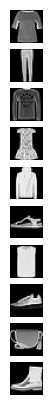

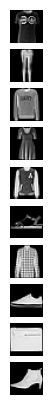

In [61]:
# visualize k-way n-shot dataset
def visualize_kway_nshot(fs_dataset):
    plt.figure(figsize=(5, 5))
    for i in range(fs_dataset.shape[0]): # k classes
        for j in range(fs_dataset.shape[1]): # n samples
            plt.subplot(fs_dataset.shape[0], fs_dataset.shape[1], i*fs_dataset.shape[1]+j+1)
            plt.imshow(fs_dataset[i][j].reshape(28, 28), cmap='gray')
            plt.axis('off')
    # plt.savefig('viz_out/kway_nshot.png')
    plt.show()

visualize_kway_nshot(fs_dataset)
visualize_kway_nshot(fs_query)

In [62]:
utils.basic_level_probing(model, fs_dataset, fs_query, device=device)

topk_indices: tensor([56, 15, 10, 36, 11, 40, 49, 17, 54, 43], device='cuda:0') torch.Size([10])
topk_query_indices: tensor([18, 15, 37, 18, 33, 16, 11, 17, 26,  5], device='cuda:0') torch.Size([10])
